## Particulate classification code

Here I take the one-hot encoded data matrix and clean the data, over-sample the data, train it on a few classification models, and then compare results. I use the scikit-learn predict() capability to see which Qs an input particle most likely belongs to, which might help create relationships between creation conditions and observed morphological traits.

The training data consits of a multiple csv files that are one-hot encoded based on features observed in particulat matter samples (are they sharp? rounded? fibrous? elongated? stringy? etc). The target variable is a Q-string which contains information about their creaiton conditions. We want to see if we can predict which Q-string a sample particulate came from. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

#### These above are the most useful math/plotting/array management modules

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

#and all the other ones
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

#random forest
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn import metrics
#from sklearn.feature_selection import RFE


######################## even more scikit-learn modules ##########
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rstate = 12 #set the random seed

------
## Now that I have imported all the modules I could ever possibly need, the next step is to read in the first csv files.  
First, I will read in the 2008 dataset using the pandas read csv command. Then I will drop the first row, as it is empty, and then use the head() suffix command to see the first few rows of the data matrix

In [2]:
#modify this below to match your own filepath!!!

grp2008_053 = pd.read_csv(r'/Users/danielgum/Documents/GitHub/Research/TextFiles/2008-053.csv')
## So now the grp2008_053 is a pandas dataframe that contains all the info
## for the 2008_053 group of particles

grp2008_053.drop(1,axis=0,inplace=True) #remove the second row, as it is empty
grp2008_053.head() #display the first few rows of the dataframe

,folder no./ comments,particle no.,STEP 1,Unnamed: 3,Unnamed: 4,STEP 2,Unnamed: 6,Unnamed: 7,STEP 3,Unnamed: 9,...,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42
0,2008-053,NaN,1.0,2.0,3.0,1.0,2.0,3.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Q016316C1000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Q016316C1010,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Q016316C1020,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Q016316C1030,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Now we see that the dataset has a few things we need to fix before we can proceed to the other particle groups.**

1. The column names are ugly and should be converted to something useful
2. The last several columns are all empty and need to be dropped
3. The "folder no." column is useless and should be dropped
4. There are several rows that have NaNs, these need to be dropped
5. Some rows are filled with all 0s, these need to be dropped (they denote particles that could not be classified)


In [3]:
#Lets modify the 2008 dataset a bit more

grp2008_053.dropna(how='all', axis = 'columns',inplace=True) #drop the extra columns of all NaNs
grp2008_053.loc[(grp2008_053!=0).any(axis=1)] #drop particles that could not be analyzed (row is all 0s)

###### now rename all the columns to redo the rows #########
grp2008_053.rename(index=str, 
columns={"folder no./ comments":"Folder Num","particle no.":"Particle No.",
         "STEP 1": "S1F1","Unnamed: 3": "S1F2", "Unnamed: 4": "S1F3", 
         "STEP 2": "S2F1","Unnamed: 6":"S2F2","Unnamed: 7":"S2F3",
         "STEP 3":"S3F1","Unnamed: 9":"S3F2","Unnamed: 10":"S3F3",
         "Unnamed: 11":"S3F4","Unnamed: 12":"S3F5","Unnamed: 13":"S3F6",
         "STEP 4 SPHERICITY":"S4F1","Unnamed: 15":"S4F2","Unnamed: 16":"S4F3",
         "STEP 4 SHAPE":"S4FA","Unnamed: 18":"S4FB","Unnamed: 19":"S4FC",
         "Unnamed: 20":"S4FD","Unnamed: 21":"S4FE","Unnamed: 22":"S4FF",
         "Unnamed: 23":"S4FG","Unnamed: 24":"S4FH","Unnamed: 25":"S4FI",
         "Unnamed: 26":"S4FJ","Unnamed: 27":"S4FK","Unnamed: 28":"S4FL", 
         "Unnamed: 29":"S4FM", "Unnamed: 30":"S4FN", "Unnamed: 31":"S4FO","Unnamed: 32":"S4FP" },inplace=True)

grp2008_053["Folder Num"] = '2008-053'
#rename the Folder Num column, fill it with 2008-053

These columns were renamed to a consistent naming scheme so that some standard exists between dataframes. The way it works is that the various steps in the morphology lexicon ("A lexicon for consistent description of material images for nuclear forensics" Tamasi et al) are applied to a particle. S1F1 represents step 1 feature one: the first choice on the flowchart for step 1. Likewise S1F2 is the second choice on the flowchart in step 1. 

In [4]:
#remove the first row, don't need it anymore
grp2008_053.drop(grp2008_053.index[0],inplace=True) #drop the row
grp2008_053.head() #display the modified array

#finally got the dataframe into something I can analyze

,Folder Num,Particle No.,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
2,2008-053,Q016316C1000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
3,2008-053,Q016316C1010,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,2008-053,Q016316C1020,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
5,2008-053,Q016316C1030,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
6,2008-053,Q016316C1040,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**So now we have a nice looking dataframe. We need to make all the other particle groups look like this when read in**

-------  
## Next steps:  
So what I need to do now is import all the other csv files and append them to make one gigantic table with 600ish rows (one for each unique particle) minus the particles that were not able to be categorized. 

In [5]:
### Now import the 2008_053A (different file than 2008_053, but data physically gathered at the same time)

#modify this below to match your own filepath!!!
grp2008_053A = pd.read_csv(r'/Users/danielgum/Documents/GitHub/Research/TextFiles/2008-053A.csv')

grp2008_053A.drop(1, axis=0, inplace = True) #remove the second row, as it is empty
grp2008_053A.dropna(how='all', axis = 'columns',inplace=True) #drop the extra columns of all zeros

grp2008_053A.loc[(grp2008_053A!=0).any(axis=1)] #drop particles that could not be analyzed (row is all 0s)
grp2008_053A.drop(grp2008_053A.index[0],inplace=True)

#now rename the columns
grp2008_053A.rename(index=str, 
columns={"Folder No. and comments":"Folder Num","STEP 1": "S1F1",
         "Unnamed: 3": "S1F2", "Unnamed: 4": "S1F3", "STEP 2": "S2F1",
         "Unnamed: 6":"S2F2","Unnamed: 7":"S2F3","STEP 3":"S3F1","Unnamed: 9":"S3F2",
         "Unnamed: 10":"S3F3","Unnamed: 11":"S3F4","Unnamed: 12":"S3F5","Unnamed: 13":"S3F6",
         "STEP 4 SPHERICITY":"S4F1","Unnamed: 15":"S4F2","Unnamed: 16":"S4F3","STEP 4 SHAPE":"S4FA",
         "Unnamed: 18":"S4FB","Unnamed: 19":"S4FC","Unnamed: 20":"S4FD","Unnamed: 21":"S4FE",
         "Unnamed: 22":"S4FF","Unnamed: 23":"S4FG","Unnamed: 24":"S4FH","Unnamed: 25":"S4FI",
         "Unnamed: 26":"S4FJ","Unnamed: 27":"S4FK","Unnamed: 28":"S4FL", "Unnamed: 29":"S4FM", 
         "Unnamed: 30":"S4FN", "Unnamed: 31":"S4FO","Unnamed: 32":"S4FP" },inplace=True)

grp2008_053A["Folder Num"] = '2008-053A'
#rename the folder num column, fill it with 2008-053A strings

grp2008_053A.head() #display the first few rows of the 2008_053A data


,Folder Num,Particle No.,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
2,2008-053A,Q016312C1010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2008-053A,Q016312C1020,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2008-053A,Q016312C1020,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
5,2008-053A,Q016312C1030,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6,2008-053A,Q016312C1040,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**Now we have a nice looking pandas array for the 2008_053A dataset. Next we do it for 2009 data**

-------
## 2009 Dataset
Standard data import process here, same as the previous steps.

In [6]:
#Make sure to modify this filepath on your computer!!!
grp2009_038 = pd.read_csv(r'/Users/danielgum/Documents/GitHub/Research/TextFiles/2009-038.csv')

grp2009_038.drop(1, axis=0, inplace = True) #remove the second row, as it is empty
grp2009_038.dropna(how='all', axis = 'columns',inplace=True) #drop the extra columns of all zeros

grp2009_038.loc[(grp2009_038!=0).any(axis=1)] #drop particles that could not be analyzed (row is all 0s)
grp2009_038.drop(grp2009_038.index[0],inplace=True)

#rename the columns
grp2009_038.rename(index=str, 
columns={"Unnamed: 0":"Folder Num","Unnamed: 1":"Particle No.","STEP 1": "S1F1",
         "Unnamed: 3": "S1F2", "Unnamed: 4": "S1F3", "STEP 2": "S2F1","Unnamed: 6":"S2F2",
         "Unnamed: 7":"S2F3","STEP 3":"S3F1","Unnamed: 9":"S3F2","Unnamed: 10":"S3F3",
         "Unnamed: 11":"S3F4","Unnamed: 12":"S3F5","Unnamed: 13":"S3F6","STEP 4 SPHERICITY":"S4F1",
         "Unnamed: 15":"S4F2","Unnamed: 16":"S4F3","STEP 4 SHAPE":"S4FA","Unnamed: 18":"S4FB",
         "Unnamed: 19":"S4FC","Unnamed: 20":"S4FD","Unnamed: 21":"S4FE","Unnamed: 22":"S4FF",
         "Unnamed: 23":"S4FG","Unnamed: 24":"S4FH","Unnamed: 25":"S4FI","Unnamed: 26":"S4FJ",
         "Unnamed: 27":"S4FK","Unnamed: 28":"S4FL", "Unnamed: 29":"S4FM", "Unnamed: 30":"S4FN", 
         "Unnamed: 31":"S4FO","Unnamed: 32":"S4FP" },inplace=True)

grp2009_038["Folder Num"] = '2009-038' #fill the Folder Num column with 2009-038
grp2009_038.dropna(inplace=True)

grp2009_038.tail() #show the last few lines for the dataframe


,Folder Num,Particle No.,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
197,2009-038,Q019346C8010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
198,2009-038,Q019346C8020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
199,2009-038,Q019346C8030,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
200,2009-038,Q019346C8040,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
201,2009-038,Q019346C8050,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


------
## 2010 data
Same process as before.

In [7]:
#make sure to update the filepath on your computer!!!!!!!!!!
grp2010_87 = pd.read_csv(r'/Users/danielgum/Documents/GitHub/Research/TextFiles/2010updated.csv')

grp2010_87.drop(1, axis=0, inplace = True) #remove the second row, as it is empty
grp2010_87.dropna(how='all', axis = 'columns',inplace=True) #drop the extra columns of all zeros

grp2010_87.loc[(grp2010_87!=0).any(axis=1)] #drop particles that could not be analyzed (row is all 0s)
grp2010_87.drop(grp2010_87.index[0],inplace=True)

#rename the columns
grp2010_87.rename(index=str, 
columns={"Folder no./comments":"Folder Num","STEP 1": "S1F1","Unnamed: 3": "S1F2", 
         "Unnamed: 4": "S1F3", "STEP 2": "S2F1","Unnamed: 6":"S2F2","Unnamed: 7":"S2F3",
         "STEP 3":"S3F1","Unnamed: 9":"S3F2","Unnamed: 10":"S3F3","Unnamed: 11":"S3F4",
         "Unnamed: 12":"S3F5","Unnamed: 13":"S3F6","STEP 4 SPHERICITY":"S4F1","Unnamed: 15":"S4F2",
         "Unnamed: 16":"S4F3","STEP 4 SHAPE":"S4FA","Unnamed: 18":"S4FB","Unnamed: 19":"S4FC",
         "Unnamed: 20":"S4FD","Unnamed: 21":"S4FE","Unnamed: 22":"S4FF","Unnamed: 23":"S4FG",
         "Unnamed: 24":"S4FH","Unnamed: 25":"S4FI","Unnamed: 26":"S4FJ","Unnamed: 27":"S4FK",
         "Unnamed: 28":"S4FL", "Unnamed: 29":"S4FM", "Unnamed: 30":"S4FN", "Unnamed: 31":"S4FO",
         "Unnamed: 32":"S4FP" },inplace=True)

grp2010_87["Folder Num"] = '2010-087' #fill the Folder Num column with 2010-087

grp2010_87.head() #show the first few lines of the 2010 data


,Folder Num,Particle No.,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
2,2010-087,Q019907C1010,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,2010-087,Q019907C1020,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,2010-087,Q019907C1030,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,2010-087,Q019907C1040,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
6,2010-087,Q019907C1050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


-------
## Now that we've got all the datasets imported, we can combine all them into one giant dataframe

In [10]:
#now combine all the dataframes
frames = [ grp2008_053, grp2008_053A, grp2009_038, grp2010_87] #put thim into a list
all_data = pd.concat(frames) #now concatenate the elements in the list
all_data.dropna(inplace=True) #drop all rows with NaNs

In [11]:
"""
For some reason the last few columns are being treated as objects and not numbers.
This is everything starting with S4FA and going to S4FP
convert them all to floats
"""
problem_cols = all_data.columns.values[-16:] 
problem_cols


array(['S4FA', 'S4FB', 'S4FC', 'S4FD', 'S4FE', 'S4FF', 'S4FG', 'S4FH',
       'S4FI', 'S4FJ', 'S4FK', 'S4FL', 'S4FM', 'S4FN', 'S4FO', 'S4FP'],
      dtype=object)

In [12]:
"""
Now all the numbers in the dataframe have been converted to floats and 
can be used in numerical algorithims. 
"""

for col in problem_cols:
    all_data[col] = all_data[col].astype(float)

all_data[problem_cols[1]] #check to see if it worked


2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
      ... 
271    0.0
272    0.0
273    0.0
274    0.0
275    0.0
Name: S4FB, Length: 755, dtype: float64

-----
### Q values denote creation conditions. So in oder to classify these later, we need to find how many Q values we have in total

In [14]:
# the last several rows of the dataframe are filled with zeros 
# and correspond to particles that we could not classify (assign to a class). 
# drop them

dataNOzeros = all_data.loc[(all_data.iloc[:,2:] != 0.0).any(axis=1)] 
#iloc[:,2:] corresponds to all rows, and every column after the 2nd one 
#(aka dont look at Folder num and Particle No)

dataNOzeros.tail()

,Folder Num,Particle No.,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
267,2010-087,Q019927C1040,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
268,2010-087,Q019927C1050,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,2010-087,Q019927C8010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,2010-087,Q019927C8010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
271,2010-087,Q019927C8010,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now that we have fixed this issue, find a way to count the amount of Q-values (creation conditions we have)

In [15]:
# Create a copy of the Particle No. column
Qvals_long = dataNOzeros['Particle No.'].copy()

qvals_short = [obj[0:-5] for obj in Qvals_long]
set(qvals_short) #get a list of the unique classes


{'Q016312',
 'Q016312C',
 'Q016314',
 'Q016316',
 'Q016317',
 'Q016318',
 'Q016320',
 'Q016322',
 'Q016324',
 'Q016326',
 'Q016328',
 'Q016330',
 'Q016332',
 'Q016334',
 'Q016336',
 'Q016338',
 'Q016340',
 'Q016342',
 'Q019329',
 'Q019330',
 'Q019331',
 'Q019332',
 'Q019333',
 'Q019334',
 'Q019335',
 'Q019336',
 'Q019337',
 'Q019338',
 'Q019339',
 'Q019340',
 'Q019341',
 'Q019342',
 'Q019343',
 'Q019344',
 'Q019345',
 'Q019346',
 'Q019907',
 'Q019908',
 'Q019909',
 'Q019910',
 'Q019911',
 'Q019912',
 'Q019913',
 'Q019914',
 'Q019915',
 'Q019916',
 'Q019917',
 'Q019918',
 'Q019919',
 'Q019920',
 'Q019921',
 'Q019922',
 'Q019923',
 'Q019924',
 'Q019925',
 'Q019926',
 'Q019927'}

In [16]:
"""
Notice the repeated Q016312 with the C at the end in the list above
This means we still dont have a list of unique Q values in the dataset. 
Gotta get rid of that C character
"""

qvals = [obj.replace("C","") for obj in qvals_short]
set(qvals)

{'Q016312',
 'Q016314',
 'Q016316',
 'Q016317',
 'Q016318',
 'Q016320',
 'Q016322',
 'Q016324',
 'Q016326',
 'Q016328',
 'Q016330',
 'Q016332',
 'Q016334',
 'Q016336',
 'Q016338',
 'Q016340',
 'Q016342',
 'Q019329',
 'Q019330',
 'Q019331',
 'Q019332',
 'Q019333',
 'Q019334',
 'Q019335',
 'Q019336',
 'Q019337',
 'Q019338',
 'Q019339',
 'Q019340',
 'Q019341',
 'Q019342',
 'Q019343',
 'Q019344',
 'Q019345',
 'Q019346',
 'Q019907',
 'Q019908',
 'Q019909',
 'Q019910',
 'Q019911',
 'Q019912',
 'Q019913',
 'Q019914',
 'Q019915',
 'Q019916',
 'Q019917',
 'Q019918',
 'Q019919',
 'Q019920',
 'Q019921',
 'Q019922',
 'Q019923',
 'Q019924',
 'Q019925',
 'Q019926',
 'Q019927'}

So in order to train machine learning algorithims, you need a matrix-based dataset to input to the models. As such, we remove the Folder Num and Particle No. columns and preserve the binary encoded Step1 - Step 4 data. In machine learning, the input data you train your model on is called "X" and the corresponding labels or truth values are "Y"

In [17]:
#we create a matrix that we use to train the machine learning models
#this is our X data
xdata = dataNOzeros.iloc[:,2:].copy()
xdata.head() #take just the features

#this is now our training X data

,S1F1,S1F2,S1F3,S2F1,S2F2,S2F3,S3F1,S3F2,S3F3,S3F4,...,S4FG,S4FH,S4FI,S4FJ,S4FK,S4FL,S4FM,S4FN,S4FO,S4FP
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-------- 
# Explore the dataset  
### First we do a correlation heatmap to see how the features (steps) are related

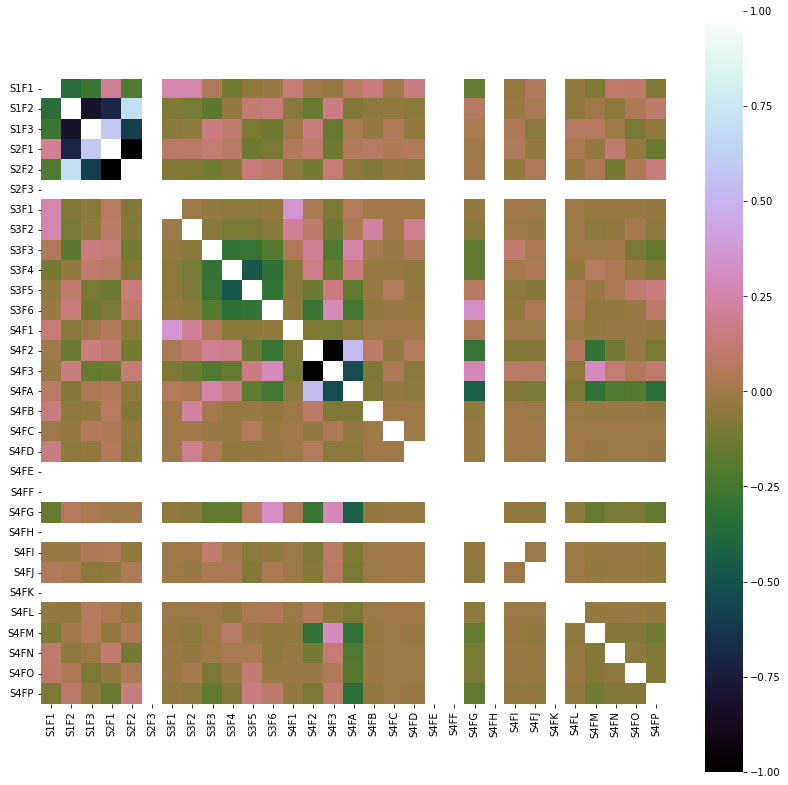

In [18]:
"""
This not only lets us see how the features are related, but also may show 
us interesting columns as well
Use the seaborn (sns) heatmap functionality to do this
"""

correlation = xdata.corr() #make a correlation plot

plt.figure(figsize=(14, 14))  
sns.heatmap(correlation, vmax=1, square=True, annot=False, cmap='cubehelix') #plot it
plt.show()# show the plot


So immediately from the above we see 5 empty columns, displayed as white bars on the correlation plot. We also see, for example, Step 1 Feature 3 is highly anti-correlated with Step 1 feature 2

---------
## Training and Testing  

**Now in order to improve machine learning performance, we want to drop the columns that are empty (the all white sections in the correlation plot above**

In [19]:
############ Drop columns that contain all zeros (remove non-important features) ######## 

# [:, (xdata != 0).any(axis=0)] means take all rows of data where xdata is not a column filled with zeros
xdata_features_removed = xdata.loc[:, (xdata != 0).any(axis=0)].copy()
xdata_features_removed.columns.values #check and make sure features were removed

array(['S1F1', 'S1F2', 'S1F3', 'S2F1', 'S2F2', 'S3F1', 'S3F2', 'S3F3',
       'S3F4', 'S3F5', 'S3F6', 'S4F1', 'S4F2', 'S4F3', 'S4FA', 'S4FB',
       'S4FC', 'S4FD', 'S4FG', 'S4FI', 'S4FJ', 'S4FL', 'S4FM', 'S4FN',
       'S4FO', 'S4FP'], dtype=object)

In [20]:
xdata_features_removed.head() #make sure we have less columns now
#26 vs 31 columns of data, looks like we're good

,S1F1,S1F2,S1F3,S2F1,S2F2,S3F1,S3F2,S3F3,S3F4,S3F5,...,S4FC,S4FD,S4FG,S4FI,S4FJ,S4FL,S4FM,S4FN,S4FO,S4FP
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-------- -------  
### Now turn the Q values into classes.
This is necessary to allow for machine learning models to make predictions. We have to transform the Qs, such as Q016316 into a numeric representation that the algorithim can learn. This is done through sckit-learn's LabelEncoder, which turns a string into a numeric label.

In [21]:
#now encode this string of project numbers to make Q categories to predict against

le = preprocessing.LabelEncoder() #initialize the LabelEncoder
le.fit(qvals) #fit the label encoder to the data
Qcategories = le.transform(qvals).copy() #transform the Q strings
Qcategories   #display it

#Now a machine learning algorithm can take in our Xdata and Qcategories to learn on

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13

Given that this is a classification problem, we should look at the distribution of data to see what we're dealing with.

------ 
In a classification problem, it helps enormously to have equal (or near equal) representation in all classes. In our case, this would be near equal counts in all Q-vals. Lets investigate to see if this is the case

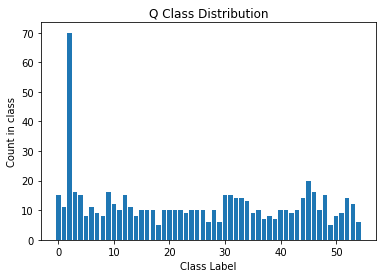

In [22]:
unique_q_list = list(set(Qcategories)) #holds the unique and non-repeated list of Qs

plt.figure() #create a figure template
plt.hist(Qcategories, bins=np.arange(len(unique_q_list))-0.5, rwidth=0.8,align='mid')
#bins = np.arange() just make a list from 0 to length of unique Qs (in this case 56), which holds the X-axis pts
#for the errorbars

plt.xlabel('Class Label') #x and y-axis labels
plt.ylabel('Count in class')
plt.title('Q Class Distribution')
plt.show()

So this is defintely not the case. We have a very imbalanced dataset. To deal with this something called over-sampling can be applied, which takes counts in the minority classes and boosts them towards equal representation with the majority class. This can be done with the imbalanced learn library .

In [23]:
from imblearn.over_sampling import SMOTE #import synthetic over-sampling

sm = SMOTE(random_state=rstate, k_neighbors=2) #initialize SMOTE oversampling

------------------------------
### Now to do this the correct way. 
Split the original dataset with 90% train, 10% test.
Oversample the 90%train, and then report accuracy metrics on the cross-val and test sets.
Here we need three datasets: Train, Validation, Test. 

In [26]:
##### Now try with smote

X_nonTest, X_test, y_nonTest, y_test = train_test_split(xdata_features_removed, 
                                                        Qcategories, test_size=0.1, random_state=rstate)
#split the data 90% nonTest so that the majority of classes get passed to oversamlping methods

X_res, y_res = sm.fit_resample(X_nonTest, y_nonTest) #SMOTE resampling makes a X_resampled and Y_resampled dataset
#now split the resampled data into train and Cross-validation

X_train, X_CV, y_train, y_CV = train_test_split(X_res, y_res, test_size=0.3, random_state=rstate)
#now train the model and report CV accuracy and Test accuracy


In [27]:
"""
Train a variety of models to see how they perform
Report the validation and training accuracy scores
"""

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    RandomForestClassifier(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
GradientBoostingClassifier(),]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions1 = clf.predict(X_CV) #get Cross-validation predictions
    train_predictions2 = clf.predict(X_train) #get test predictions
    
    accVal = accuracy_score(y_CV, train_predictions1) #get cross-validation accuracy scores
    acctrain = accuracy_score(y_train, train_predictions2) #get test accuracy scores
    

    print("Val Accuracy: {:.3%}, \nTrain Acc: {:.3%}".format(accVal, acctrain)) #print results
    
    
print("="*30)

KNeighborsClassifier
****Results****
Val Accuracy: 50.960%, 
Train Acc: 60.576%
SVC
****Results****
Val Accuracy: 35.125%, 
Train Acc: 38.683%
DecisionTreeClassifier
****Results****
Val Accuracy: 54.607%, 
Train Acc: 76.584%
RandomForestClassifier
****Results****
Val Accuracy: 55.086%, 
Train Acc: 75.761%
RandomForestClassifier
****Results****
Val Accuracy: 55.374%, 
Train Acc: 75.556%
BernoulliNB
****Results****
Val Accuracy: 37.812%, 
Train Acc: 41.605%
LinearDiscriminantAnalysis
****Results****
Val Accuracy: 36.948%, 
Train Acc: 40.576%


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


GradientBoostingClassifier
****Results****
Val Accuracy: 50.096%, 
Train Acc: 76.584%


----------
Now what if you want to take the class imbalance into greater account?
We need to use (and should be using from here on out) balanced test accuracy. It is the same steps as before, just with a tweak in the output scores. No need to change the Xdata and ylabels from before, we can keep that.  

Balanced accuracy is a better metric for imbalanced classification problems, and when using the adjusted=True setting below, the range of values is can take is $\frac{1}{1-n_{classes}}$  to 1 inclusive. A score of zero represents random chance guessing, and above zero describing the relative increase from random guessing.

In [28]:
#code block just as before, not much has changed

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
GradientBoostingClassifier(),]


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions1 = clf.predict(X_CV) #get Cross-validation predictions
    train_predictions2 = clf.predict(X_test) #get test predictions
    
    accVal = balanced_accuracy_score(y_CV, train_predictions1, adjusted=True) #get balanced CV accuracy scores
    acctest = balanced_accuracy_score(y_test, train_predictions2, adjusted=True) #get balanced test accuracy scores
    

    print("Balanced Val Accuracy: {:.3%}, \nBalanced Test Acc: {:.3%}".format(accVal, acctest)) #print results
    
    
print("="*30)


KNeighborsClassifier
****Results****
Balanced Val Accuracy: 50.042%, 
Balanced Test Acc: 18.137%


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


SVC
****Results****


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Applications/anaconda3/lib/

Balanced Val Accuracy: 34.374%, 
Balanced Test Acc: 16.667%
DecisionTreeClassifier
****Results****
Balanced Val Accuracy: 54.411%, 
Balanced Test Acc: 15.686%
RandomForestClassifier
****Results****
Balanced Val Accuracy: 55.484%, 
Balanced Test Acc: 14.216%
BernoulliNB
****Results****
Balanced Val Accuracy: 37.006%, 
Balanced Test Acc: 11.275%
LinearDiscriminantAnalysis
****Results****
Balanced Val Accuracy: 35.657%, 
Balanced Test Acc: 13.824%
GradientBoostingClassifier
****Results****
Balanced Val Accuracy: 49.020%, 
Balanced Test Acc: 14.216%


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Now what if you're personally interested in giving the classifier a test particle and seeing for yourself what Q it predicts it to be in? We use the predict_proba() funtion to do that.

In [29]:
"""
Take the already trained classifier we made in the last step 
(it is stored in the variable clf)
Give it to a particle in Xtest
"""

X_test.iloc[[0]]

,S1F1,S1F2,S1F3,S2F1,S2F2,S3F1,S3F2,S3F3,S3F4,S3F5,...,S4FC,S4FD,S4FG,S4FI,S4FJ,S4FL,S4FM,S4FN,S4FO,S4FP
37,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
#Now lets pass it into the ML algorithm

prediction_probs = clf.predict_proba(X_test.iloc[[0]])
prediction_probs #display it

array([[7.17958472e-04, 2.60262406e-03, 6.33912331e-04, 8.37404656e-01,
        5.97893605e-04, 1.21251565e-05, 2.17613060e-06, 4.31892770e-04,
        6.57181422e-05, 8.39588000e-03, 1.58655478e-03, 1.24730175e-03,
        6.27848622e-02, 9.93408550e-05, 1.27934320e-02, 3.11517966e-05,
        2.38590396e-05, 1.78758341e-04, 4.13685477e-05, 7.12533288e-06,
        6.29609677e-04, 1.26373405e-05, 7.43454316e-06, 6.35235748e-04,
        2.12309005e-05, 8.82935469e-06, 8.75477187e-05, 3.61038579e-05,
        2.07166669e-03, 2.52648217e-07, 1.87871057e-03, 2.03920395e-04,
        5.77322040e-02, 1.25917829e-03, 2.26636524e-04, 2.87369974e-05,
        1.21470937e-04, 2.85232409e-05, 2.80529558e-04, 1.86008957e-03,
        3.12952443e-04, 1.43532718e-03, 1.01624032e-06, 5.01184989e-05,
        1.72847789e-04, 1.66039217e-07, 2.34250896e-06, 5.70326509e-04,
        1.62773167e-04, 8.25049476e-07, 2.97535464e-06, 9.04287978e-06,
        1.59215142e-07, 2.41415770e-05, 4.20258069e-04, 4.558735

In [31]:
prediction = clf.predict(X_test.iloc[[0]])
prediction #display it

array([3])

In [32]:
le.inverse_transform(prediction)

array(['Q016317'], dtype='<U7')

Now you have a trained model that can predict which class a test particle comes from. This methodology can be extended to larger datasets in this problem-space, and allows a user to pick their model of choice and hyperparamter tune to achieve better results. 

In [33]:
#if you wanted to do some hyperparameter tuning, it would look like this
# Use grid search cv to do an exhaustive search over the passed hyperparamters

parameters = {
    'learning_rate':[0.1,0.05,0.01],
    'n_estimators':[50,100,200,500,1000],
    'max_depth':[1,2,3,4,5]
}

gradboost = GradientBoostingClassifier()
clf = GridSearchCV(gradboost, parameters)
clf.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [35]:
clf.best_params_ #now show the best parameters found in the hyperparamter tuning

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000}

In [43]:
tuned_model = GradientBoostingClassifier(learning_rate = clf.best_params_['learning_rate'],
                                        max_depth = clf.best_params_['max_depth'],
                                        n_estimators = clf.best_params_['n_estimators'])
tuned_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [46]:
tuned_preds = tuned_model.predict(X_test)
tuned_acc = balanced_accuracy_score(tuned_preds, y_test, adjusted = True)
print('Tuned model has balanced acc score of: ', tuned_acc) #looks like an improvement

Tuned model has balanced acc score of:  0.17043010752688173


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
